In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('..')
os.getcwd()

'/home/yermaand/audio-nn'

In [3]:
from src import *

In [4]:
def calculate_errors(model, config, offsets = [0]):
    dists_to_center = []
    abs_errors = []

    for offset in offsets:
        for file in config.testing_files:
            video = Video(file, config)
            from_time, till_time = video.get_from_till_time(Part.WHOLE)
            from_time = from_time + offset
            probs = validate_video(video, model, return_preds=False, from_time=from_time, till_time=till_time, classification=True)
            preds, n_predicted = inference(probs, config)
            labels = get_labels(video, from_time, till_time)

            mask = labels['n_counts'] != 0

            dist_to_center = labels['dist_to_center'][mask]
            n_counts = labels['n_counts'][mask]
            preds = preds['n_counts'][mask]
            
            abs_error = np.abs(preds - n_counts)

            dists_to_center.extend(dist_to_center)
            abs_errors.extend(abs_error)

    dists_to_center = np.array(dists_to_center)
    abs_errors = np.array(abs_errors)

    return dists_to_center, abs_errors


def plot_errors(dists_to_center, abs_errors, N=30):
    mean_abs_errors = []

    X = np.linspace(0, 3, N)
    for i, j in zip(range(0, N - 1), range(1, N)):
        mask = (X[i] <= dists_to_center) & (X[j] > dists_to_center)
        mean_abs_error = abs_errors[mask].mean()
        mean_abs_errors.append(mean_abs_error)

    plt.plot(X[range(0, N - 1)], mean_abs_errors)

    return mean_abs_errors

### Example

[0.15384615384615385,
 0.06666666666666667,
 0.2631578947368421,
 0.29411764705882354,
 0.0,
 0.29411764705882354,
 0.0,
 0.14285714285714285,
 0.32,
 0.3333333333333333,
 0.4166666666666667,
 0.11538461538461539,
 0.4,
 0.19047619047619047,
 0.3333333333333333,
 0.41379310344827586,
 0.3793103448275862,
 0.27586206896551724,
 0.28,
 0.5757575757575758,
 0.375,
 0.24242424242424243,
 0.3333333333333333,
 0.40476190476190477,
 0.4634146341463415,
 0.5555555555555556,
 0.3877551020408163,
 0.7105263157894737,
 0.8333333333333334]

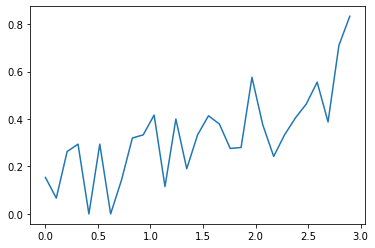

In [6]:
uuid = '020_RX100_resized_128/0'
model, config = load_model_locally(uuid, model_name='rvce')
dists_to_center, abs_errors = calculate_errors(model, config)
plot_errors(dists_to_center, abs_errors)

### Validate all

In [5]:
dists_to_center_folds = []
abs_errors_folds = []
for i in range(5):
    uuid = f'020_RX100_resized_128/{i}'
    model, config = load_model_locally(uuid, model_name='rvce')
    dists_to_center, abs_errors = calculate_errors(model, config, offsets=[0, 0.5, 1, 1.5, 2, 2.5, 3])
    dists_to_center_folds.append(dists_to_center)
    abs_errors_folds.append(abs_errors)

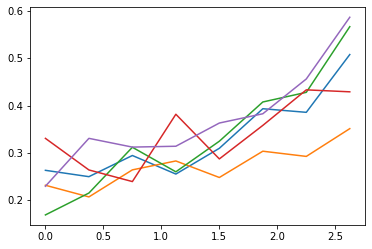

In [6]:
N = 9
mean_abs_errors_folds = []
for dists_to_center, abs_errors in zip(dists_to_center_folds, abs_errors_folds):
    mean_abs_errors = plot_errors(dists_to_center, abs_errors, N=N)
    mean_abs_errors_folds.append(mean_abs_errors)

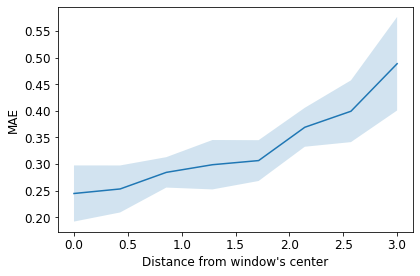

In [8]:
X = np.linspace(0, 3, N - 1)
means = np.mean(mean_abs_errors_folds, axis=0)
stds = np.std(mean_abs_errors_folds, axis=0)

import matplotlib
matplotlib.rcParams['font.size'] = 12

# plt.figure(figsize=(7, 5))
plt.ylabel('MAE')
plt.xlabel('Distance from window\'s center')
plt.plot(X, np.mean(mean_abs_errors_folds, axis=0))
plt.fill_between(X, means - stds, means + stds, alpha=0.2)
plt.tight_layout()
plt.savefig('plots/influence_of_near_border_events_on_accuracy.pdf')